In [2]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import color # For rgb2la & lab2rgb
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class AverageMeter:
    def __init__(self):
        self.reset()
        self.history_losses = []

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1, acc=False):
        if acc:
            self.count += count
            self.sum += val
            self.avg = self.sum / self.count
        else:
            self.count += count
            self.sum += count * val
            self.avg = self.sum / self.count
        self.history_losses.append(val)

def clear_losses(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss_meter.reset()
        
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    class_loss = AverageMeter()
    class_accuracy = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G,
            'class_loss': class_loss,
            'class_accuracy': class_accuracy}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        try:
            if loss_name == 'class_accuracy':
                acc = True
            else:
                acc=False
            loss = getattr(model, loss_name)
            loss_meter.update(loss.item(), count=count, acc=acc)
        except AttributeError:
            pass

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        if loss_name == 'class_accuracy':
            print(f"{loss_name}: {loss_meter.avg:.5f}%")
        else:
            print(f"{loss_name}: {loss_meter.avg:.5f}") 

In [69]:
# Generate dummy data
st_col_stats = create_loss_meters()
st_cls_stats = create_loss_meters()
mt_stats = create_loss_meters()
for i in range(10):

    # (Combined) discriminator loss (multi-task and single-task: col)
    st_col_stats['loss_D'].update(float(torch.rand(1)*5))
    mt_stats['loss_D'].update(float(torch.rand(1)*5))

    # Generator loss(es) (multi-task and single-task: col)
    # NOTE: Colorization score is weighted sum of GAN and L1 (use the correct weight!)
    mt_stats['loss_G'].update(float(torch.rand(1)*5))
    mt_stats['loss_G_GAN'].update(float(torch.rand(1)*5))
    mt_stats['loss_G_L1'].update(float(torch.rand(1)*5))
    st_col_stats['loss_G'].update(float(torch.rand(1)*5))
    st_col_stats['loss_G_GAN'].update(float(torch.rand(1)*5))
    st_col_stats['loss_G_L1'].update(float(torch.rand(1)*5))

    # Classification stats (multi-task and single-task: cls)
    mt_stats['class_loss'].update(float(torch.rand(1)*5))
    mt_stats['class_accuracy'].update(float(torch.rand(1)))
    st_cls_stats['class_loss'].update(float(torch.rand(1)*5))
    st_cls_stats['class_accuracy'].update(float(torch.rand(1)))

print("[MT] Class accuracies:", mt_stats['class_accuracy'].history_losses)
torch.save(st_col_stats, './st_col_stats.ckpt')
torch.save(st_cls_stats, './st_cls_stats.ckpt')
torch.save(mt_stats, './mt_stats.ckpt')

[MT] Class accuracies: [0.8865270018577576, 0.5925402641296387, 0.40161097049713135, 0.8278224468231201, 0.7125005722045898, 0.5184970498085022, 0.9445307850837708, 0.4095807671546936, 0.5772903561592102, 0.800320029258728]


In [71]:
# NOTE: Assumes 'loss_meter_dict.ckpt' exists (run cell above to create dummy)
st_col_stats_ld = torch.load("./st_col_stats.ckpt")
st_cls_stats_ld = torch.load("./st_cls_stats.ckpt")
mt_stats_ld     = torch.load("./mt_stats.ckpt")
print("(Loaded) [MT] Class accuracies:", mt_stats_ld['class_accuracy'].history_losses)

(Loaded) [MT] Class accuracies: [0.8865270018577576, 0.5925402641296387, 0.40161097049713135, 0.8278224468231201, 0.7125005722045898, 0.5184970498085022, 0.9445307850837708, 0.4095807671546936, 0.5772903561592102, 0.800320029258728]


In [72]:
import warnings

def plot_stat(stats, plot_type, title, x_label, y_label):
    warnings.filterwarnings("ignore", category=FutureWarning)
    # TODO: Mess with theme
    if plot_type == 'line':
        for name, values in stats.items():
            sns.lineplot(values, label=name)
    elif plot_type == 'cm':
        pass
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.show()
    warnings.filterwarnings("default", category=FutureWarning)


#### Plot multi-task loss

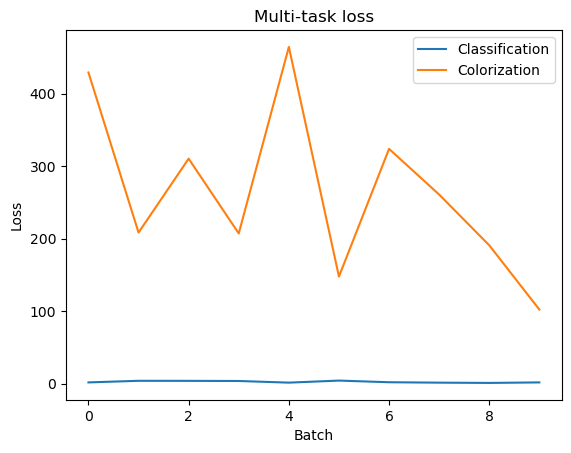

In [73]:
# NOTE: While these are synthetic data, we should probably (add and) tune the classification
# loss's weight such that they are comparable, right?
L1_fac = 100
classification_losses = mt_stats_ld['class_loss'].history_losses
colorization_losses   = [gan_loss + L1_fac * l1_loss for gan_loss, l1_loss in zip(mt_stats_ld['loss_G_GAN'].history_losses, mt_stats_ld['loss_G_L1'].history_losses)]
plot_stat({'Classification': classification_losses,
           'Colorization': colorization_losses},
           'line', "Multi-task loss", "Batch", "Loss")

### Plot multi- vs single-task classification accuracy

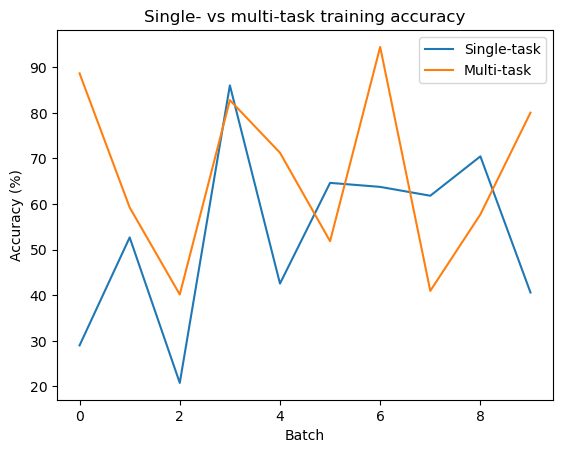

In [81]:
st_cls_accuracies = [100 * acc for acc in st_cls_stats_ld['class_accuracy'].history_losses]
mt_cls_accuracies = [100 * acc for acc in mt_stats_ld['class_accuracy'].history_losses]
plot_stat({'Single-task': st_cls_accuracies,
           'Multi-task': mt_cls_accuracies},
           'line', "Single- vs multi-task training accuracy", "Batch", "Accuracy (%)")

### Plot multi- vs single-task colorization loss

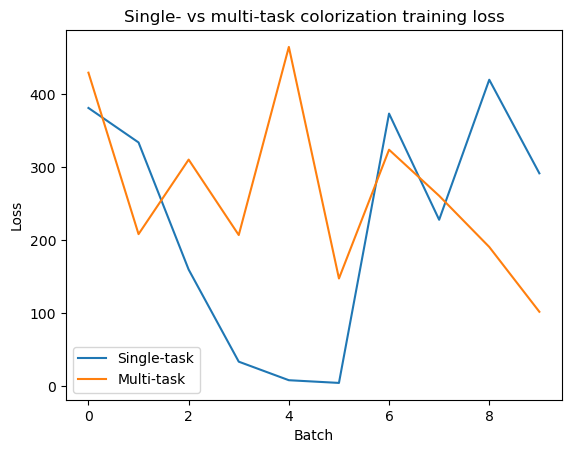

In [85]:
# NOTE: Could be interesting to compare L1 and GAN losses separately too...
st_col_losses = [gan_loss + L1_fac * l1_loss for gan_loss, l1_loss in zip(st_col_stats_ld['loss_G_GAN'].history_losses, st_col_stats_ld['loss_G_L1'].history_losses)]
mt_col_losses = [gan_loss + L1_fac * l1_loss for gan_loss, l1_loss in zip(mt_stats_ld['loss_G_GAN'].history_losses, mt_stats_ld['loss_G_L1'].history_losses)]
plot_stat({'Single-task': st_col_losses,
           'Multi-task': mt_col_losses},
           'line', "Single- vs multi-task colorization training loss", "Batch", "Loss")

### Classification confusion matrix

In [89]:
from sklearn.metrics import confusion_matrix

BATCH_SIZE = 128

# TODO: Use actual validation set
x_val, y_val = torch.rand((BATCH_SIZE, 28, 28)), torch.rand((BATCH_SIZE, 5))
x_val = x_val.to(device)
y_val = y_val.to(device)

mt_gen     = MLTModel(head='multitask')
st_col_gen = MLTModel(head='colorization')
mt_model     = MainModel(net_G=mt_gen)
st_col_model = MainModel(net_G=st_col_gen)

mt_model.load_state_dict(torch.load("mt.pt"))
st_col_model.load_state_dict(torch.load("st_col.pt"))

# Compute predictions
with torch.no_grad():
    #test_out, _ = batch_forward_prop(rnn, x_test, y_test)
    mt_val_out     = mt_model.forward(x_val)
    st_col_val_out = st_col_model.forward(x_val)

# Transform them into hard predictions
mt_preds     = mt_val_out.argmax(dim=1)
st_col_preds = st_col_val_out.argmax(dim=1)

# Compute the confusion matrix
mt_y_true = y_val.cpu().numpy()
mt_cm = confusion_matrix(y_val, mt_preds)
mt_cm = mt_cm.astype('float64')

st_col_y_true = y_val.cpu().numpy()
st_col_cm = confusion_matrix(y_val, st_col_preds)
st_col_cm = st_col_cm.astype('float64')

# Normalize each row
for i in range(mt_cm.shape[0]):
    mt_cm[i, :]     = mt_cm[i, :]     / sum(mt_cm[i, :])
    st_col_cm[i, :] = st_col_cm[i, :] / sum(st_col_cm[i, :])

class_names = ['lionfish', 'pufferfish', 'sea-anemone', 'sea-cucumber', 'sea-snake']

plt.figure(figsize=(10, 10))
plt.imshow(mt_cm)
plt.xticks(range(len(class_names)), class_names.keys(), rotation='vertical')
plt.yticks(range(len(class_names)), class_names.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

NameError: name 'mt_model' is not defined